# Лабораторна робота №1
#### Виконав Грибенко Єгор, ІП-93
Варіант - 9
>Вирази для обчислення:  
E=В\*МС+D\* min(MC)  
MА=b\*MD\*(MC-MX)+MX\*MC\*b

In [1]:
"""Імпортуємо необхідні бібліотеки:"""
from threading import Thread # бібліотека для виконання коду у різних потоках
import numpy as np # бібліотека для роботи з матрицями (але функції операцій роботи з матрицями будемо писати самими, пізніше поясню чому)
from numpy.random import random as rand # функція для генерації матриць з випадкових чисел
from time import time # Бібліотека для роботи з часом. За допомогою неї розрахуємо час роботи потрібного коду.
from colorama import Fore as color # Бібліотека для кольрового виводу в консолі
import json # Бібліотека для запису даних в json
import os.path # бібліотека для роботи з файлами та директоріями

In [2]:
"""Створюємо клас, який дозволить нам повертати значення з потоків виконання коду"""
class ThreadWithReturnValue(Thread):
	def __init__(self, target=None, args=()): Thread.__init__(self, target=target, args=args)
	def run(self): self._return = self._target(*self._args)
	def join(self): Thread.join(self); return self._return

In [3]:
"""Створюємо функцію, за допомогою якої будемо заміряти час виконання коду"""
def measure_time(f):
	def measure(*args): start=time(); res=f(*args); end = time(); t = end-start; return {'result': res, 'time': t}
	return measure

In [4]:
"""
Метод суми за алгоритмом Кохана. Змінні суми та числа C ми будемо оголошувати
ззовні функції, а саму функцію ми будемо викликати, щоб оновлювати ці змінні суми та С
"""
def kahan_sum(sum, c, val):
	y = val - c
	t = sum + y
	c = (t - sum) - y
	sum = t
	return sum, c

In [5]:
"""Створюємо метод, за допомогою якого будемо ділити операцію множення за рядками матриці (2 версія програми)"""
calculation_threads = 2
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [6]:
"""
Клас Матриця містить всі операції, які ми будемо виконувати над матрицями.
Я також застосував перевантаження операторів, щоб потім було зручно писати формули з матрицями.
Операції з матрицями ми пишемо вручну для того, щоб ми могли розуміти, чи вони виконуються в 1 потоці, чи в кількох.
Також ми робимо це для того, щоб розраховувати операції із використанням алгоритма Кохана, який був згаданий в умові лабораторних робіт.
Якби ми використовували готові операції з бібліотеки numpy, то вони автоматично виконувались би в максимальній кількості потоків,
що одразу вбиває весь сенс багатопоточної програми нашої лабораторної роботи, бо паралелити обчислення вже нікуди. 
Втім, при реальній роботі з матрицями краще використовувати такі бібліотеки, бо вони працюють блискавично.
"""
class Matrix:
	def __init__(self, data):
		self.data: np.ndarray = data

	def __repr__(self):
		return str(self.data)

	def __array__(self):
		return self.data

	def __add__(self, other):
		match self.data.shape, other.data.shape:
			case (int(x), int(y)), (int(z), int(w)): # matrix + matrix
				return self.add_matrix_matrix(other)
			case (int(x),), (int(y),): # vector + vector
				return self.add_vec_vec(other)
			case _, _:
				raise "Addition error!"

	def __sub__(self, other): # matrix - matrix
		if self.data.shape[0] != other.data.shape[0] or self.data.shape[1] != other.data.shape[1]:
			raise ValueError('Matrices must be of same dimensions to subtract.')
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			for j in range(self.data.shape[1]):
				result.data[i][j] = self.data[i][j] - other.data[i][j]
		return result

	def __rmul__(self, other):
		match self, other:
			case Matrix(), float(x): # float * matrix
				return Matrix(self.data * x)
			case _, _:
				raise "Multiplication error!"

	def __mul__(self, other):
		match self.data, other:
			case np.ndarray(shape=(int(_),)), float(x): # vector * float
				return self.mul_vec_scalar(other)
			case np.ndarray(shape=(int(_), int(_))), float(x): # matrix * float
				return self.mul_matrix_scalar(other)
		
		match self.data.shape, other.data.shape:
			case (int(_), int(_)), (int(_), int(_)): # matrix * matrix
				return self.mul_matrix_matrix(other)
			case (int(_),), (int(_), int(_)): # vector * matrix
				return self.mul_vec_matrix(other)
			case _, _:
				raise "Multiplication error!"

	def __pow__(self, other):
		return self.mul_matrix_matrix_threaded(other)

	def mul_matrix_matrix_threaded(self, other):
		if self.data.shape[1] != other.data.shape[0]:
			raise ValueError('The number of columns of the first matrix must be the same as the number of rows of the second matrix.')
		result = Matrix(np.zeros((self.data.shape[0], other.data.shape[1])))

		def partial_prod(destination, rangei, rangej):
			for i in rangei:
				for j in rangej:
					sum = 0.0
					c = 0.0
					for k in range(self.data.shape[1]):
						sum, c = kahan_sum(sum, c, self.data[i][k] * other.data[k][j])
					destination.data[i][j] = sum

		rangei = range(self.data.shape[0])
		rangej = range(other.data.shape[1])

		thread_ranges = split(rangei, calculation_threads)
		threads = []
		for rangei in list(thread_ranges):
			threads += [Thread(target=partial_prod, args=(result, rangei, rangej))]

		for t in threads: t.start()
		for t in threads: t.join()

		return result

	def add_matrix_matrix(self, other):
		if self.data.shape[0] != other.data.shape[0] or self.data.shape[1] != other.data.shape[1]:
			raise ValueError('Matrices must be of same dimensions to add.')
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			for j in range(self.data.shape[1]):
				result.data[i][j] = self.data[i][j] + other.data[i][j]
		return result

	def add_vec_vec(self, other):
		if self.data.shape[0] != other.data.shape[0]:
			raise ValueError("Vectors must have the same length.")
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			result.data[i] = self.data[i] + other.data[i]
		return result

	def mul_matrix_matrix(self, other):
		if self.data.shape[1] != other.data.shape[0]:
			raise ValueError('The number of columns of the first matrix must be the same as the number of rows of the second matrix.')
		result = Matrix(np.zeros((self.data.shape[0], other.data.shape[1])))
		for i in range(self.data.shape[0]):
			for j in range(other.data.shape[1]):
				sum = 0.0
				c = 0.0
				for k in range(self.data.shape[1]):
					sum, c = kahan_sum(sum, c, self.data[i][k] * other.data[k][j])
				result.data[i][j] = sum
		return result

	def mul_vec_scalar(self, other):
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			result.data[i] = self.data[i] * other
		return result

	def mul_matrix_scalar(self, other):
		result = Matrix(np.zeros(self.data.shape))
		for i in range(self.data.shape[0]):
			for j in range(self.data.shape[1]):
				result.data[i][j] = self.data[i][j] * other
		return result

	def mul_vec_matrix(self, other):
		return Matrix(np.matmul(self, other))

	@classmethod
	def Min(cls, matrix) -> float:
		return np.min(matrix)

	@classmethod
	def from_ndarray(cls, arr):
		return Matrix(*arr.shape, data=arr)

	@classmethod
	def from_json(cls, json_string):
		data = json.loads(json_string)
		return Matrix(np.array(data['data']))

	def to_json(self):
		data = {'data': self.data.tolist()}
		return json.dumps(data)


In [7]:
"""Тут створюємо функцію, яка буде генерувати змінні зі значеннями з діапазону 0-10000"""
MAX_FLOAT = 10000
generate_variables = lambda size: {
	**{i: Matrix(rand((size)) * MAX_FLOAT) for i in ['B', 'D']},
	**{i: Matrix(rand((size, size)) * MAX_FLOAT) for i in ['MC', 'MD', 'MX']},
	'b': rand() * MAX_FLOAT
}

In [8]:
"""Зі згенерованих значень ми створюємо файл у форматі json. Наступні функції роблять саме це."""
def variable_to_json(var):
	match var:
		case float(x):
			return x
		case Matrix() as m:
			return m.to_json()

def generate_and_save_to_json(filename, matrix_sizes):
	data = []
	for size in matrix_sizes:
		data.append({k: variable_to_json(v) for k, v in generate_variables(size).items()})
	with open(filename, "w") as outfile:
		outfile.write(json.dumps(data))

In [9]:
"""Наступні функції я створив для читання наших змінних з формату json."""
def is_float(element: any) -> bool:
    try:
        float(element)
        return True
    except ValueError:
        return False

variable_from_json = lambda x: float(x) if is_float(x) else Matrix.from_json(x) 

def read_json(filename):
	with open(filename, "r") as file:
		return file.read()

def json_to_variables(filename):
	data = json.loads(read_json(filename))

	for i in range(len(data)):
		data[i] = {k: variable_from_json(v) for k, v in data[i].items()}
	
	return data

In [10]:
"""
Нарешті, пишемо реалізацію першої версії програми.
Як ми вже пам'ятаємо, при використанні операторів над нашими матрицями, виконується відповідна задана вручну операція в класі Matrix.
"""
def version_1():
	def calc_E(variables: dict):
		B, D, MC, MD, MX, b = variables.values()
		# E = В * МС + D * min(MC)
		E = B * MC + D * Matrix.Min(MC)
		print(color.GREEN + f"E: {E}")
		return E

	def calc_MA(variables: dict):
		B, D, MC, MD, MX, b = variables.values()
		# # MА = b * MD * (MC - MX) + MX * MC * b
		MA = b * MD * (MC - MX) + MX * MC * b
		print(color.GREEN + f"MA: {MA}")
		return MA

	def run_program(variables, output):
		tasks = [*map(measure_time, [calc_E, calc_MA])]
		threads = [*map(lambda f: ThreadWithReturnValue(target=f, args=(variables,)), tasks)]
		[*map(lambda t: t.start(), threads)]
		result = [*map(lambda t: t.join(), threads)]
		return result

	def run_and_measure(variables, output):
		res = measure_time(run_program)(variables, output)
		print(color.RED + f"time: {res['time']}")
		return res

	def get_work_result(input, output):
		separate_run_time_results = []
		run_time_results = []
		sizes = []
		for variables in input:
			res = run_and_measure(variables, output)
			
			out = dict(zip(['E', 'MA'], res['result']))
			output.write(str(out) + '\n')

			separate_run_time_results += [{k: v["time"] for k, v in out.items()}]
			run_time_results += [res]
			sizes += [variables['B'].data.shape[0]]
		return sizes, run_time_results, separate_run_time_results

	return get_work_result


In [11]:
"""
Друга версія програми відрізняється від першої тим, що має глобальні змінні, які є спільними між потоками програми.
Тут я визначив оператор ** як багатопоточне множення матриці. Відповідний метод, який з ним викликається, можна побачити вище в класі Matrix - називається _pow_().
"""
def version_2():
	def calc_E(variables: dict):
		B, D, MC, MD, MX, b = variables.values()
		# E = В * МС + D * min(MC)
		E = B * MC + D * Matrix.Min(MC)
		print(color.GREEN + f"E: {E}")
		return E

	def calc_MA(variables: dict):
		B, D, MC, MD, MX, b = variables.values()
		# MА = b * MD * (MC - MX) + MX * MC * b
		MA = b * MD ** (MC - MX) + MX ** MC * b
		print(color.GREEN + f"MA: {MA}")
		return MA

	def run_program(variables, output):
		tasks = [*map(measure_time, [calc_E, calc_MA])]
		threads = [*map(lambda f: ThreadWithReturnValue(target=f, args=(variables,)), tasks)]
		[*map(lambda t: t.start(), threads)]
		result = [*map(lambda t: t.join(), threads)]
		return result

	def run_and_measure(variables, output):
		res = measure_time(run_program)(variables, output)
		print(color.RED + f"time: {res['time']}")
		return res

	def get_work_result(input, output):
		separate_run_time_results = []
		run_time_results = []
		sizes = []
		for variables in input:
			res = run_and_measure(variables, output)
			
			out = dict(zip(['E', 'MA'], res['result']))
			output.write(str(out) + '\n')

			separate_run_time_results += [{k: v["time"] for k, v in out.items()}]
			run_time_results += [res]
			sizes += [variables['B'].data.shape[0]]
		return sizes, run_time_results, separate_run_time_results

	return get_work_result


In [12]:
"""Тут я визначаю функцію для відображення графіків залежності часу роботи програми від розмірності матриць"""

import matplotlib.pyplot as plt
def visualize_work(version, input, output, ax, version_id):
	sizes, data, calc_data = version()(input, output)
	calc_E_times = [i['E'] for i in calc_data]
	calc_MA_times = [i['MA'] for i in calc_data]
	times = [row['time'] for row in data]
	
	ax[0].plot(sizes, times, label=f'Whole program run time - version {version_id}')
	ax[1].plot(sizes, calc_E_times, label=f'Calculation E time - version {version_id}')
	ax[1].plot(sizes, calc_MA_times, label=f'Calculation MA time - version {version_id}')

In [13]:
"""Тут встановлюю файли вводу-виводу, генерую вхідні змінні, якщо файл не існує, а також очищую файл виводу"""

input_name = "input.json"
output_name = "output.txt"

if not os.path.isfile(input_name):
	generate_and_save_to_json(input_name, range(100, 200, 15))

open(output_name, 'w').close() # Очищення файла

E: [44.5238593  40.06365191 39.98068215 37.7341344  40.13548472 39.96256021
 38.62287912 37.85486714 38.61492595 39.32103976 39.76770817 38.53243993
 36.59280581 37.67374404 37.03923968 37.98826157 36.00601641 35.64957296
 34.96930294 39.9025914  37.7350463  36.91558073 38.39711801 40.64848929
 37.10556808 35.63864288 40.40425905 37.47845057 39.78529271 38.78272618
 37.08835913 40.37016472 40.00161116 36.3974934  39.13999082 35.7776729
 39.09782728 40.13103616 39.98711716 38.70398854 36.92662029 37.86252052
 37.26035811 41.26987768 41.94958456 38.26742535 40.1127669  34.89595418
 38.95673596 35.76398145 39.57909232 39.53916284 39.74294572 38.655248
 35.65564767 38.48146199 38.85319633 35.0522705  36.05786879 33.95669935
 37.83406431 40.61741518 36.42264156 37.89783672 37.80069095 42.06143068
 35.39487084 39.72510285 35.27247678 37.44018909 42.50206884 38.31980518
 38.14238411 37.27381901 37.48958174 38.23167832 36.60291146 36.85074241
 40.57249737 34.80771685 36.96105205 36.83756021 38

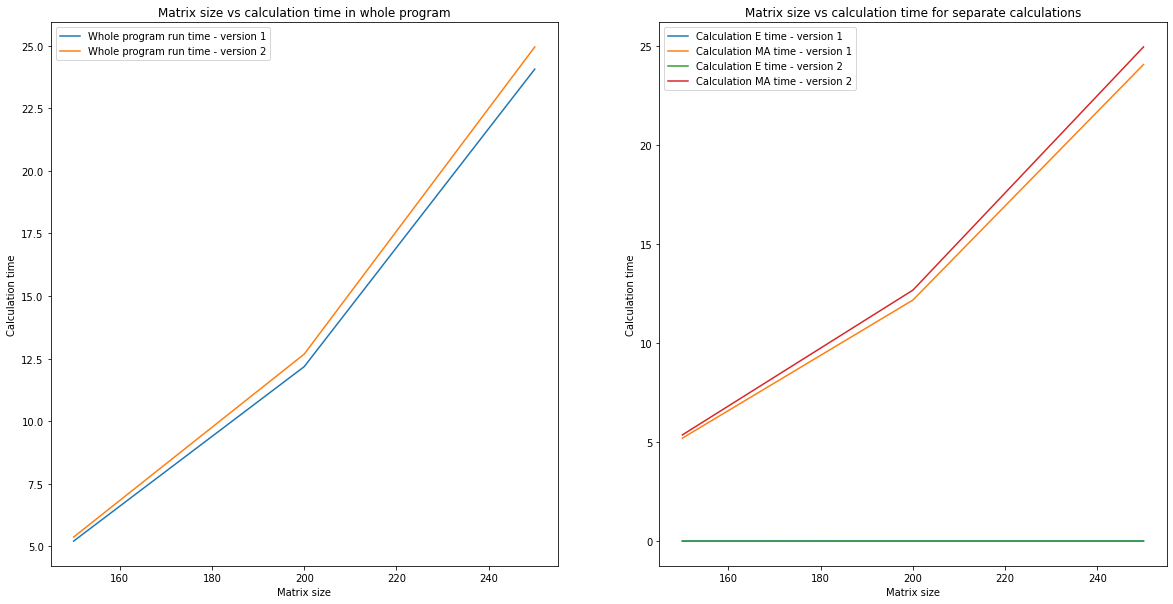

In [14]:
"""
І, нарешті, останній шматок коду, з якого відбувається запуск обчислень та вивід результатів.
Іронічно, але вони мене неприємно здивували, про що детально розповім у звіті з лабораторної роботи.
"""

input = json_to_variables(input_name)

with open(output_name, 'a') as output:
	fig, ax = plt.subplots(1, 2)
	fig.set_size_inches(20, 10)
	visualize_work(version_1, input, output, ax, 1)
	visualize_work(version_2, input, output, ax, 2)

	ax[0].set_title('Matrix size vs calculation time in whole program')
	ax[1].set_title('Matrix size vs calculation time for separate calculations')

	for a in ax.tolist():
		a.set_xlabel('Matrix size')
		a.set_ylabel('Calculation time')
		a.legend()

	plt.show()
